<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 5: Practical - Recurrent Neural Networks <br>
<font color=696880 size=4>
    Alireza Farashah, Parsa Hosseini
    
    
____


### Full Name : Armin Saghafian
### Student Number : 99105345
___

# Image Captioning using Recurrent Neural Networks
In this notebook we want to implement a deep neural network to caption Flickr images. It has 8091 images and each image in this dataset has an ID and there are 5 caption for each image in captions.txt file which is uploaded in Quera. We use pretrained ResNet50 model to get meaningful features from each image. Code of this part is implemented and you have to use id_to_feature and id_to_caption dictionary. See the code to understand what are these two dictionaries.
You have to implement the empty parts of this notebook.

# Import Libaries and Dataset

In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
from copy import deepcopy
from PIL import Image
import string
import gdown
import pickle

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
!unzip /content/Flickr8k_Dataset.zip -d /content/images/

In [4]:
!unzip /content/captions.txt.zip -d /content/text/

unzip:  cannot find or open /content/captions.txt.zip, /content/captions.txt.zip.zip or /content/captions.txt.zip.ZIP.


# Creating Features and Captions Dcitionary

In [ ]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

94765736/94765736 [==============================] - 4s 0us/step


In [5]:
url = 'https://drive.google.com/file/d/17CyOxXVJBBL4xIh-YxBN-KmVpjIIgqsu/view?usp=sharing'
output_path = 'features.pk'
gdown.download(url, output_path, quiet=False,fuzzy=True)


# for name in tqdm(os.listdir("/content/images/Flicker8k_Dataset")):
#     img = img_to_array(load_img("/content/images/Flicker8k_Dataset/" + name, target_size=(224,224)))
#     img = preprocess_input(img.reshape((1, img.shape[0], img.shape[1], img.shape[2])))
#     feature = resnet50.predict(img, verbose=0)
#     id_to_features[name.split('.')[0]]=feature

Downloading...
From: https://drive.google.com/uc?id=17CyOxXVJBBL4xIh-YxBN-KmVpjIIgqsu
To: /content/features.pk
100%|██████████| 66.8M/66.8M [00:00<00:00, 178MB/s]


'features.pk'

In [6]:
id_to_features = {}

objectRep = open("features.pk", "rb")
id_to_features = pickle.load(objectRep)

In [7]:
id_to_features['587604325_af5d6df679'].shape

(1, 2048)

In [8]:
len(id_to_features)

8091

In [9]:
from itertools import islice

id_to_captions = {}

with open("/content/text/captions.txt", 'r') as f:
    for i, line in enumerate(f):
        if i==0:
            continue
        tokens = line.split('.jpg,')
        id, caption = tokens[0], tokens[1]
        if id not in id_to_captions:
            id_to_captions[id] = []
        id_to_captions[id].append(caption) 

In [10]:
len(id_to_captions)

8091

In [11]:
id_to_captions['587604325_af5d6df679']

['A curly haired dog tries to bite another dog wearing a green and orange collar .\n',
 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .\n',
 'Two brown dogs playing .\n',
 '"Two dogs , one with its mouth open ."\n',
 'Two golden dogs playing with one another\n']

# Preprocessing and Tokenizing (15 points)

In this part you need to clean the captions text in order to use Tokenizer.

In [12]:
# preprocess caption texts
def preprocessing(id_caption):
    for key, captions in id_caption.items():
        for i in range(len(captions)):
            caption: str = captions[i]

            caption = caption.lower()
            caption = caption.replace('"', '').replace('[^A-Za-z\s]', '')
            caption = caption.replace('\s+', ' ')
            caption = ' '.join( [w for w in caption.split() if len(w)>1] )
            caption = '<start> '  + caption + ' <end>'

            captions[i] = caption

In [13]:
preprocessing(id_to_captions)
id_to_captions['587604325_af5d6df679']

['<start> curly haired dog tries to bite another dog wearing green and orange collar <end>',
 '<start> one brown dog is bearing its teeth at another brown dog with green collar in park <end>',
 '<start> two brown dogs playing <end>',
 '<start> two dogs one with its mouth open <end>',
 '<start> two golden dogs playing with one another <end>']

## Data Generator (25 points)

In this part implement a data generator function to use during the training.
For each image and caption you have to create number of train samples in the following format.

caption: "start_char the man is playing football end_char"

sample 0: X="start_char", Y="the "

sample 1: X="start_char the", Y="man"

...

sample n: X="start_char the man is playing football", Y="end_char"

In [30]:
all_captions = []
for k in id_to_captions:
    for caption in id_to_captions[k]:
        all_captions.append(caption)

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_len = len(tokenizer.word_index) + 1
max_len = np.max([len(cap.split()) for cap in all_captions])
max_len

34

In [32]:
# create data generator 
def data_generator(keys, id_to_captions, id_to_features, tokenizer, max_len, vocab_len, batch_size):
    features, sequences, targets = list(),list(),list()
    n = 0
    while(True):
        for k in keys:
            n += 1
            for caption in id_to_captions[k]:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    x, y = seq[:i], seq[i]
                    x = pad_sequences([x], maxlen=max_len)[0]
                    y = to_categorical([y],num_classes = vocab_len)[0]
                    features.append(id_to_features[k][0])
                    sequences.append(x)
                    targets.append(y)
            if n == batch_size:
                features = np.array(features)
                sequences = np.array(sequences)
                targets = np.array(targets)
                yield [[features, sequences], targets]

                features, sequences, targets = list(),list(),list()
                n = 0



## Model (20 points)

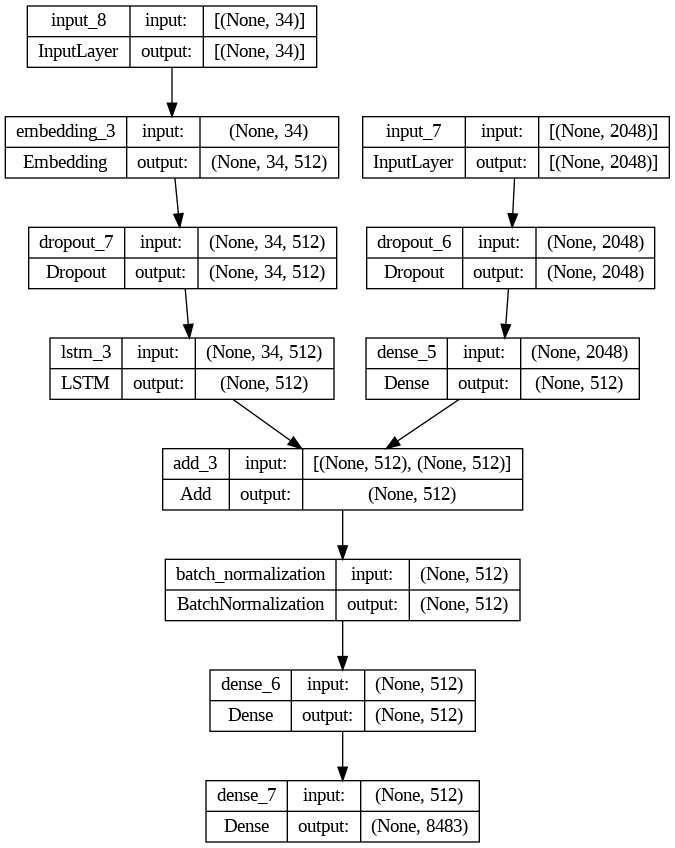

In [81]:
# define the model
inputs1 = layers.Input(shape=(2048, ))
features1 = layers.Dropout(0.5)(inputs1)
features2 = layers.Dense(512,activation="relu")(features1)

inputs2 = layers.Input(shape = (max_len,))
seq1 = layers.Embedding(vocab_len, 512, mask_zero = True)(inputs2)
seq2 = layers.Dropout(0.5)(seq1)
seq3 = layers.LSTM(512)(seq2)

adder = layers.add([features2,seq3])
norm = layers.BatchNormalization()(adder)
decoder = layers.Dense(512,activation = "relu")(norm)
outputs = layers.Dense(vocab_len,activation = "softmax")(decoder)
model = Model(inputs = [inputs1,inputs2], outputs = outputs)
model.compile(loss = "categorical_crossentropy",optimizer="adam")

plot_model(model, show_shapes=True)

# Train (10 points)

Train the model and plot loss for training data.

In [22]:
## make train and test datasets
image_id = list(id_to_features.keys())

split = int(len(image_id) * 0.9)

train_keys = image_id[:split]
test_keys = image_id[split:]

In [83]:
# train the model
epochs = 10
batch_size = 32
steps = len(train_keys) // batch_size
for i in range(epochs):
    generator = data_generator(train_keys, id_to_captions, id_to_features, tokenizer, max_len, vocab_len, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps)


227/227 [==============================] - 71s 313ms/step - loss: 2.0209


In [17]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## save model to drive

In [102]:
model.save('model.h5')

In [103]:
import shutil
shutil.copy("model.h5","/content/drive/MyDrive/")

'/content/drive/MyDrive/model.h5'

## get model from drive

In [26]:
import shutil
shutil.copy("/content/drive/MyDrive/model.h5", "/content/")

'/content/model.h5'

In [27]:
model = tf.keras.models.load_model('model.h5')

## Test (30)

In this part evaluate the model and generate caption for 10 of test images. For evaluation use "bert-base-uncased" pretrained model and calculate similarity for the predicted sentence of model and real captions. 
Show 3 of the images and predictied samples.

In [28]:
def generate_caption(model, tokenizer, features, max_len):
    answer = '<start>'
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([answer])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        pred = model.predict([features, sequence], verbose=0)
        pred = np.argmax(pred)
        word = tokenizer.sequences_to_texts([[pred]])[0]
        if word is None:
            break
        answer += ' ' + word
        if word == 'end':
            break
    return answer

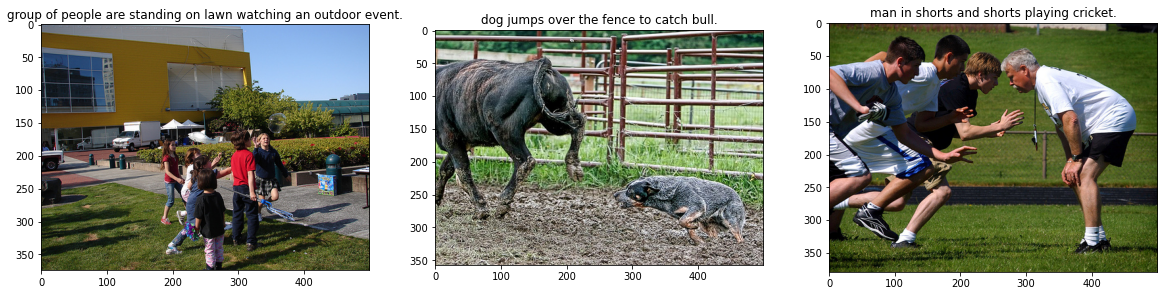

In [24]:
fig = plt.figure(figsize=(20, 10))
for i in range(3):
    key = np.random.choice(test_keys)
    img = Image.open(f"/content/images/Flicker8k_Dataset/{key}.jpg")
    description = generate_caption(model, tokenizer, id_to_features[key], max_len)
    description = description.replace("<start> ", "").replace(" end", ".")
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(img)
    ax.set_title(description)

In [ ]:
!pip install transformers

In [40]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",)
bertmodel = AutoModel.from_pretrained("bert-base-uncased",output_hidden_states=True)


def get_embeddings(text,token_length):
    embedding = bert_tokenizer.encode(text, max_length=token_length, padding='max_length')
    return embedding

def calculate_similarity(text1,text2,token_length=20):
    text1_embedding = np.array(get_embeddings(text1,token_length)).reshape(1, -1)
    text2_embedding = np.array(get_embeddings(text2,token_length)).reshape(1, -1)
    similarity = cosine_similarity(text1_embedding, text2_embedding)
    return similarity[0][0]

for i in range(10):
    key = np.random.choice(test_keys)
    description = generate_caption(model, tokenizer, id_to_features[key], max_len).replace("end", "<end>")
    actual_caption = id_to_captions[key][0]
    print("predicted caption: " + description)
    print("actual caption: " + actual_caption)
    print(calculate_similarity(description, actual_caption, max_len))
    print("#############################################################")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


predicted caption: <start> two hikers are walking down grassy hill <end>
actual caption: <start> person hiking at the foot of snowcapped mountains <end>
0.6313381848705216
#############################################################
predicted caption: <start> man is climbing rock wall <end>
actual caption: <start> man crouches down to take picture <end>
0.4172815332052693
#############################################################
predicted caption: <start> white dog is running through the grass <end>
actual caption: <start> cat sits alone in dry grass <end>
0.7760007701463301
#############################################################
predicted caption: <start> boy in an orange shirt is walking on wet sidewalk <end>
actual caption: <start> child in yellow overalls is walking over packed dirt <end>
0.8992774591115149
#############################################################
predicted caption: <start> two girls are playing in the park with their arms around <end>
actual caption